# V1 Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
import matplotlib as mpl
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 0.5
%matplotlib inline

from scipy.io import loadmat
from tqdm import tqdm

from collections import namedtuple

import datajoint as dj
import numpy as np
import pandas as pd
from v1_likelihood import train, analysis
from v1_likelihood.analysis import LikelihoodStats
from v1_likelihood.utils import bin_loc, binned_group, binned_stats
from itertools import count, product
from collections import OrderedDict
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.stats import ttest_rel, wilcoxon, ttest_1samp
from scipy.stats import norm
from matplotlib import patches
from matplotlib import transforms
from matplotlib.patches import ConnectionPatch

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connecting eywalker@10.28.0.34:3306


In [2]:
from collections import namedtuple

Aggregate = namedtuple('Aggregate', ['resp_a', 'model_correct', 'logl', 'presp_a'])
def aggr_model_perf(key, lc_id=32, decoder_id=3, lc_shuffle_id=0):
    restr = dict(lc_id=lc_id, decoder_id=decoder_id, lc_shuffle_id=lc_shuffle_id)
    data = (cd_dlset.CVSet.Member * cd_dlset.LCModelFits & key & restr).fetch()
    aggr = {}
    ordering = np.concatenate(data['test_indices'], axis=1)
    pos = np.argsort(ordering.squeeze())
    model_choice = np.concatenate(data['model_choice'])[pos].squeeze()
    model_correct = np.concatenate(data['model_correct'])[pos].squeeze()
    logl = np.concatenate(data['lc_test_logl'])[pos].squeeze()
    presp_a = np.exp(logl)
    presp_a[model_choice != model_correct] = 1 - presp_a[model_choice != model_correct]
    return Aggregate(model_choice, model_correct, logl, presp_a)
    

In [3]:
def significance_indicator(p):
    if p < 0.005:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return None

In [4]:
cd_dataset = dj.create_virtual_module('cd_dataset', 'edgar_cd_dataset')
class_discrimination = dj.create_virtual_module('class_discrimination', 'edgar_class_discrimination')
cd_lc = dj.create_virtual_module('cd_lc', 'edgar_cd_lc')
cd_dlset = dj.create_virtual_module('cd_dlset', 'edgar_cd_dlset');
ephys = dj.create_virtual_module('ephys', 'ephys')
stimulation = dj.create_virtual_module('stimulation', 'stimulation')

In [5]:
def add_subplots(*args, fig=None):
    if fig is None:
        fig = plt.gcf()
    return [fig.add_subplot(gs) for gs in args]

In [6]:
def get_summary(restr=None, subject=None, model=32, decoder=3, shuffle=0):
    if restr is None:
        restr = {}
    if subject is not None:
        subj = 'subject_id = {}'.format(subject)
    else:
        subj = {}
    target = (cd_dlset.CVSet * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash') * class_discrimination.CSCLookup * class_discrimination.CleanSpikeCountSet & restr & subj)
    cvset = target.fetch('KEY', order_by=','.join(target.primary_key))

    cond = dict(lc_id=model, decoder_id=decoder, lc_shuffle_id=shuffle)
    contrasts = np.array([float(c['dataset_contrast']) for c in cvset])

    list_model_resp_A = []
    list_monkey_resp_A = []
    list_test_logl = []
    list_correct_resp = []
    list_cont_vals = []
    list_n_trials = []
    
    for i, c in enumerate(cvset):
        data = (cd_dlset.LCModelFits & c & cond).fetch(order_by='cv_n')
        test_logl = np.concatenate(data['lc_test_logl'])
        n_trials = len(test_logl)
        list_cont_vals.append([float(c['dataset_contrast'])] * n_trials)
        list_n_trials.append(n_trials)
        list_test_logl.append(test_logl)
        model_resp = np.exp(test_logl)
        model_choice = [d.squeeze() for d in data['model_choice']]
        model_correct = [d.squeeze() for d in data['model_correct']]
        model_resp_A = np.concatenate(model_choice)
        correct_resp = np.concatenate(model_correct)
        list_correct_resp.append(correct_resp)
        monkey_resp_A = (model_resp_A == correct_resp)
        list_monkey_resp_A.append(monkey_resp_A)
        model_resp_A = model_resp.copy()
        model_resp_A[~monkey_resp_A] = 1 - model_resp_A[~monkey_resp_A]
        list_model_resp_A.append(model_resp_A)

    summary = {}
    summary['contrast'] = contrasts
    summary['correct_resp'] = list_correct_resp
    summary['model_resp_A'] = list_model_resp_A
    summary['monkey_resp_A'] = list_monkey_resp_A
    summary['test_logl'] = list_test_logl
    summary['n_trials'] = list_n_trials
    summary['cont_vals'] = list_cont_vals
    
    return summary

## Configure plot RC

In [7]:
# make font exportable
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.0
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2.0
mpl.rcParams['ytick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

mpl.rcParams['xtick.minor.size'] = 1.0
mpl.rcParams['ytick.minor.size'] = 1.0

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['font.size'] = 6.0
mpl.rcParams['font.sans-serif'] = ['Liberation Sans']



tom_color = np.array([1, 1, 1]) * 0
leo_color = np.array([1, 1, 1]) * 0.5
tom_marker = '^'
leo_marker = 'X'
cp = sns.color_palette("RdBu_r")

c1_color = cp[-1]
c2_color = cp[0]

# Figure 1 - Behavioral information

In [9]:
leo_data = (class_discrimination.ClassDiscriminationTrial & class_discrimination.CleanSpikeCountTrials & 'subject_id = 3').fetch()
tom_data = (class_discrimination.ClassDiscriminationTrial & class_discrimination.CleanSpikeCountTrials & 'subject_id = 21').fetch()
all_data = (class_discrimination.ClassDiscriminationTrial & class_discrimination.CleanSpikeCountTrials).fetch()

[0.005 0.01  0.02  0.03  0.05  0.1   0.9  ]


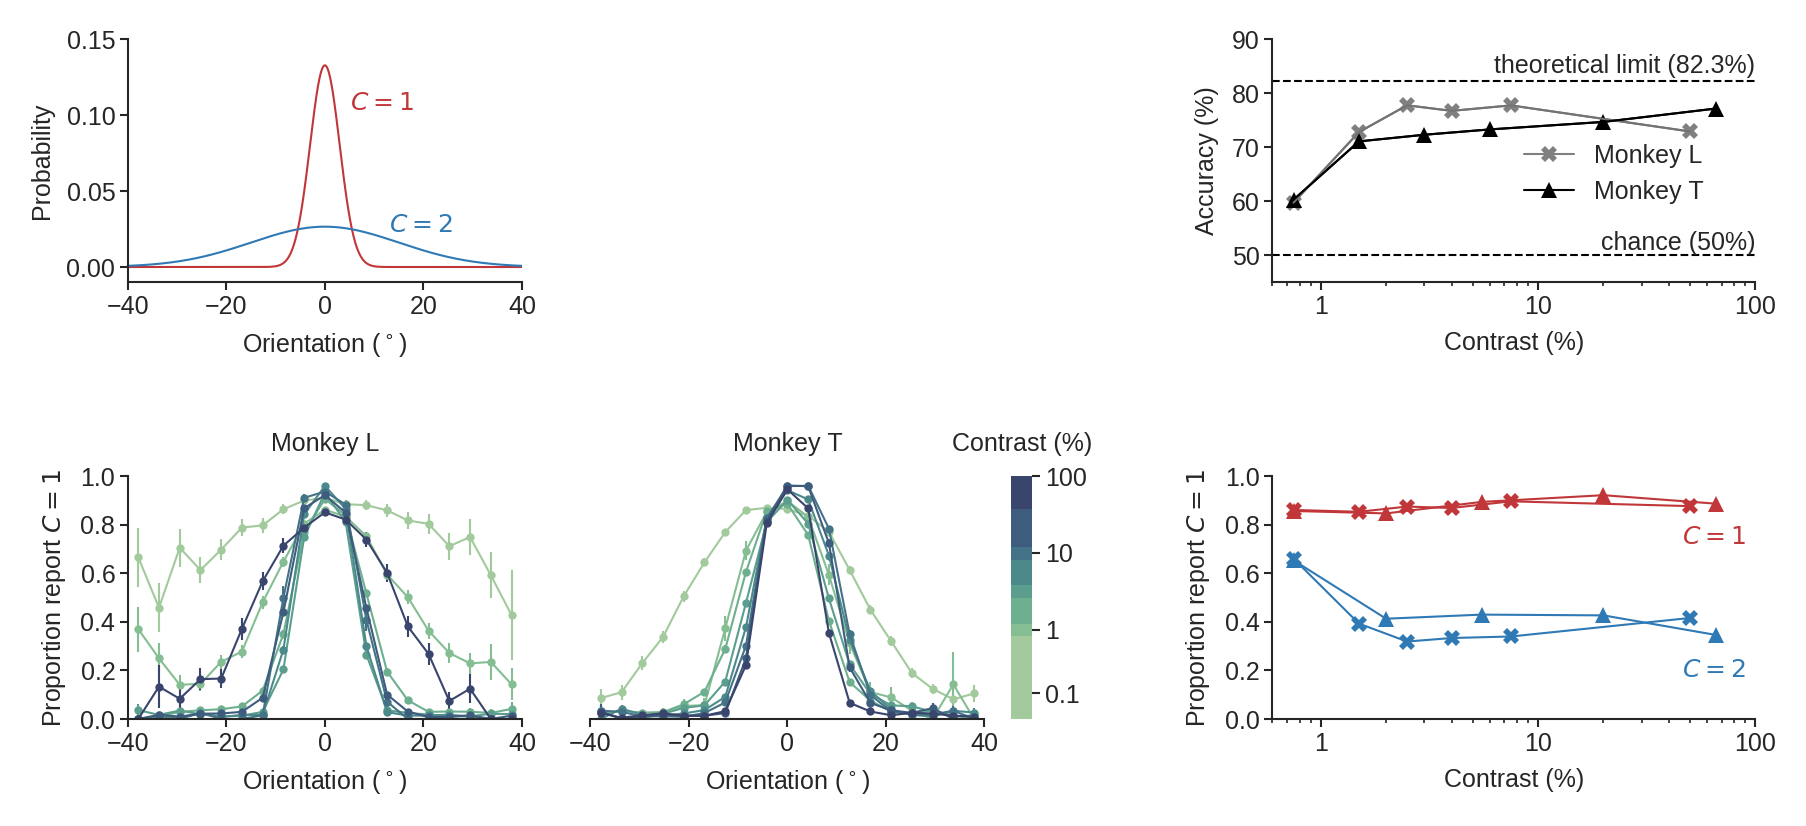

In [10]:
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
markersize=4


fig = plt.figure(figsize=(7, 3), dpi=300)

gs = gridspec.GridSpec(2, 11, hspace=0.8, wspace=0.8)
gs_right = gridspec.GridSpec(2, 1, hspace=0.8, wspace=0.8, left=0.67)

gs_performance = gs_right[0, 0]
gs_cond_response = gs_right[1, 0]

gs_distr = gs[0, :3]
gss_psychometric = gs[1, :3], gs[1, 3:6]
gs_colormap = gs[1, 6]


# plot probablity distributions
ax, = add_subplots(gs_distr)
ori = np.linspace(-50, 50, 8000)
sigma_a = 3
sigma_b = 15

pa = np.exp(-ori**2/2/sigma_a**2)/np.sqrt(2 * np.pi * sigma_a**2)
pb = np.exp(-ori**2/2/sigma_b**2)/np.sqrt(2 * np.pi * sigma_b**2)


delta = (ori[-1] - ori[0]) / len(ori)
mixed = 0.5 * (pa + pb)

choice_a = pa > pb
prop_a = pa[choice_a] / (pa[choice_a] + pb[choice_a]) * mixed[choice_a] * delta
choice_b = ~choice_a
prop_b = pb[choice_b] / (pa[choice_b] + pb[choice_b]) * mixed[choice_b] * delta

p_correct = prop_a.sum() + prop_b.sum()

linewidth=0.5
ax.plot(ori, pa, color=c1_color, linewidth=linewidth, label='C=1')
ax.text(5, 0.1, '$C=1$', verticalalignment='bottom', horizontalalignment='left', fontsize=fs, color=c1_color)
ax.plot(ori, pb, color=c2_color, linewidth=linewidth, linestyle='-', label='C=2')
ax.text(13, 0.02, '$C=2$', verticalalignment='bottom', horizontalalignment='left', fontsize=fs, color=c2_color)


ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel(r'Probability', fontsize=fs, labelpad=labelpad)
ax.set_ylim([-0.01, 0.15])
ax.set_xlim([-40, 40])
ax.set_yticks([0,0.05, 0.1, 0.15])
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
#ax.legend(fontsize=fs)


#### Plot conditioned response  ######
ax, = add_subplots(gs_cond_response)
select_a = (tom_data['selected_class'] == 'A').astype(float)
stim_class = (tom_data['stimulus_class'] == 'A')
contrasts = tom_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 6))

ra_conda = select_a[stim_class]
cont_conda = contrasts[stim_class]
ra_condb = select_a[~stim_class]
cont_condb = contrasts[~stim_class]

stats = binned_stats(cont_conda, ra_conda, cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker=tom_marker, ms=markersize, color=c1_color)
stats = binned_stats(cont_condb, ra_condb,  cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker=tom_marker, linestyle='-', ms=markersize, color=c2_color)

select_a = (leo_data['selected_class'] == 'A').astype(float)
stim_class = (leo_data['stimulus_class'] == 'A')
contrasts = leo_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))

ra_conda = select_a[stim_class]
cont_conda = contrasts[stim_class]
ra_condb = select_a[~stim_class]
cont_condb = contrasts[~stim_class]

stats = binned_stats(cont_conda, ra_conda, cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker=leo_marker, ms=markersize, color=c1_color)
ax.text(0.9, 0.8, '$C=1$', verticalalignment='top', horizontalalignment='right', fontsize=fs, color=c1_color)
stats = binned_stats(cont_condb, ra_condb, cont_edges)
ax.errorbar(stats.binc, stats.mu, stats.sem, marker=leo_marker, linestyle='-', ms=markersize, color=c2_color)
ax.text(0.9, 0.25, '$C=2$', verticalalignment='top', horizontalalignment='right', fontsize=fs, color=c2_color)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([0.45, 1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel(r'Proportion report $C=1$', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)


#### Performance curve ######
ax, = add_subplots(gs_performance)

contrasts = leo_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
print(cont_edges)
correct = leo_data['correct_response'].astype(float) * 100
stats = binned_stats(contrasts, correct, cont_edges)

ax.plot(stats.binc, stats.mu, marker=leo_marker, ms=markersize, label='Monkey L', color=np.r_[leo_color, [1]])
ax.errorbar(stats.binc, stats.mu, stats.sem, color=leo_color*0.9)

contrasts = tom_data['contrast'].astype(float)
cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
correct = tom_data['correct_response'].astype(float) * 100

stats = binned_stats(contrasts, correct, cont_edges)

ax.plot(stats.binc, stats.mu, marker=tom_marker, ms=markersize, label='Monkey T', color=np.r_[tom_color, [1]])
ax.errorbar(stats.binc, stats.mu, stats.sem, color=tom_color*0.9)

ax.axhline(p_correct * 100, linestyle='--', color='k')
ax.text(1, p_correct *100 + 0.5, 'theoretical limit (82.3%)', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.axhline(50, linestyle='--', color='k')
ax.text(1, 50.05, 'chance (50%)', verticalalignment='bottom', horizontalalignment='right', fontsize=fs)

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([45, 90])
ax.set_yticks([50, 60, 70, 80, 90])
tx=ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Accuracy (%)', fontsize=fs, labelpad=labelpad)
ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
#ax.minorticks_off()



##### Psychometric functions #####
# set color
colors = sns.cubehelix_palette(12, start=0.5, rot=-.75)[2:]
sns.set_palette(colors)
axs = add_subplots(*gss_psychometric)
ori_edges = np.linspace(-40, 40, 20)
cont_edges = np.percentile(all_data['contrast'], np.linspace(0, 100, 9))


for i, ax, data_source, title in zip(count(), axs, [leo_data, tom_data], ['Monkey L', 'Monkey T']):
    contrasts = data_source['contrast'].astype(float)
    correct = data_source['correct_response'].astype(float)
    ori = data_source['orientation'] - 270
    resp_a = (data_source['selected_class'] == 'A').astype(float)
    

    contc = 0.5 * (cont_edges[1:] + cont_edges[:-1])
    
    for g, c in zip(binned_group(contrasts, cont_edges), contc):
        x = ori[g]
        y = resp_a[g]
        stats = binned_stats(x, y, ori_edges)
        ax.errorbar(stats.binc, stats.mu, stats.sem, marker='o', markersize=2, label='{:.1f}'.format(c*100))
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-40, 40])
    ax.set_ylim([0, 1])
    ax.set_xticks([-40, -20, 0, 20, 40])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
    if i==0:
        ax.set_ylabel(r'Proportion report $C=1$', fontsize=fs, labelpad=labelpad)
        sns.despine(offset=offset, ax=ax, trim=trim)
    else:
        #legend = ax.legend(title='Binned\ncontrast (%)', loc='upper left', bbox_to_anchor=[1.05, 1.2], fontsize=fs, )
        #legend.get_title().set_fontsize(fs)
        ax.set_yticks([])
        sns.despine(offset=offset, ax=ax, trim=trim, left=True)
    ax.tick_params(labelsize=fs, pad=pad)

###### Colormap for psychometric function ####
ax, = add_subplots(gs_colormap)
v = np.logspace(np.log10(0.0005), np.log(0.99), 20)[:, None]
cadj = cont_edges.copy()
pos = np.sum(v >= cont_edges, axis=1, keepdims=True)-1
pos[pos<0] = 0
tickloc = np.array([0.001, 0.01, 0.1, 1])
tickpos = np.argmin(np.abs(v - tickloc), axis=0)
sns.heatmap(pos, cmap=colors[:8], vmin=-0.5, vmax=7.5, ax=ax, cbar=False)
ax.set_yticks(tickpos + 0.5)
ax.set_ylim([0.5, 19.5])
ax.set_yticklabels([0.1, 1, 10, 100], fontsize=fs, rotation=0)
ax.set_xticks([])
ax.set_title('Contrast (%)', fontsize=fs)
ax.yaxis.tick_right()
bounds = list(ax.get_position().bounds)
bounds[0] -= 0.02
bounds[2] = bounds[2]/4
ax.set_position(bounds)
ax.tick_params(labelsize=fs, pad=pad)

fig.savefig('figures/fig02.pdf')
fig.savefig('figures/fig02.png', dpi=200)
#fig.tight_layout()

# Figure 2: Raw data and processing sequence

In [55]:
#header = class_discrimination.CleanSpikeCountSet * class_discrimination.CSCLookup * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash')
#keys = (header * cd_dlset.CVSet & 'subject_id = 21').fetch('KEY')
#key = keys[214]
key = {
    'count_start': 0,
    'count_stop': 500,
    'csc_hash': '8b19498cf522fff44c6f14c2c6a33cc5955d18a7',
    'cv_n': 10,
    'cv_seed': 498365,
    'dataset_contrast': '0.64',
    'dec_trainset_hash': '991410b681da0d8be353ef8264895eed17f45b7e',
    'dec_trainset_owner': 'cd_dataset.CleanContrastSessionDataSet',
    'detect_method_num': 1,
    'ephys_start_time': 3521828723041,
    'event_type': 'showStimulus',
    'post_stim_time': 300,
    'pre_stim_time': 300,
    'scu_id': 0,
    'session_start_time': 3521828718682,
    'setup': 2,
    'sort_method_num': 4,
    'stim_start_time': 3521828748157,
    'subject_id': 21
}

contrast = float(key['dataset_contrast'])

decoder_id = 3
trial_data = (class_discrimination.ClassDiscriminationTrial * class_discrimination.SpikeCountTrials & class_discrimination.CleanSpikeCountTrials & key).fetch(order_by='trial_num')
trial_data = trial_data[trial_data['contrast'] == contrast]
likelihood_data = loadmat((cd_dlset.DLSetInfo & 'decoder_id={} and lc_shuffle_id=1'.format(decoder_id) & key).fetch1('dataset_path'))['dataSet'][0, 0]
l_stats = (LikelihoodStats & key & 'decoder_id={} and lc_shuffle_id=0'.format(decoder_id)).fetch1()
bayes_model_resp = aggr_model_perf(key, lc_id=32, decoder_id=decoder_id, lc_shuffle_id=0)
nb_model_resp = aggr_model_perf(key, lc_id=38, decoder_id=decoder_id, lc_shuffle_id=0)
print('Contrast={}, {} trials found'.format(contrast, len(trial_data)))

Contrast=0.64, 987 trials found


Using seed 320


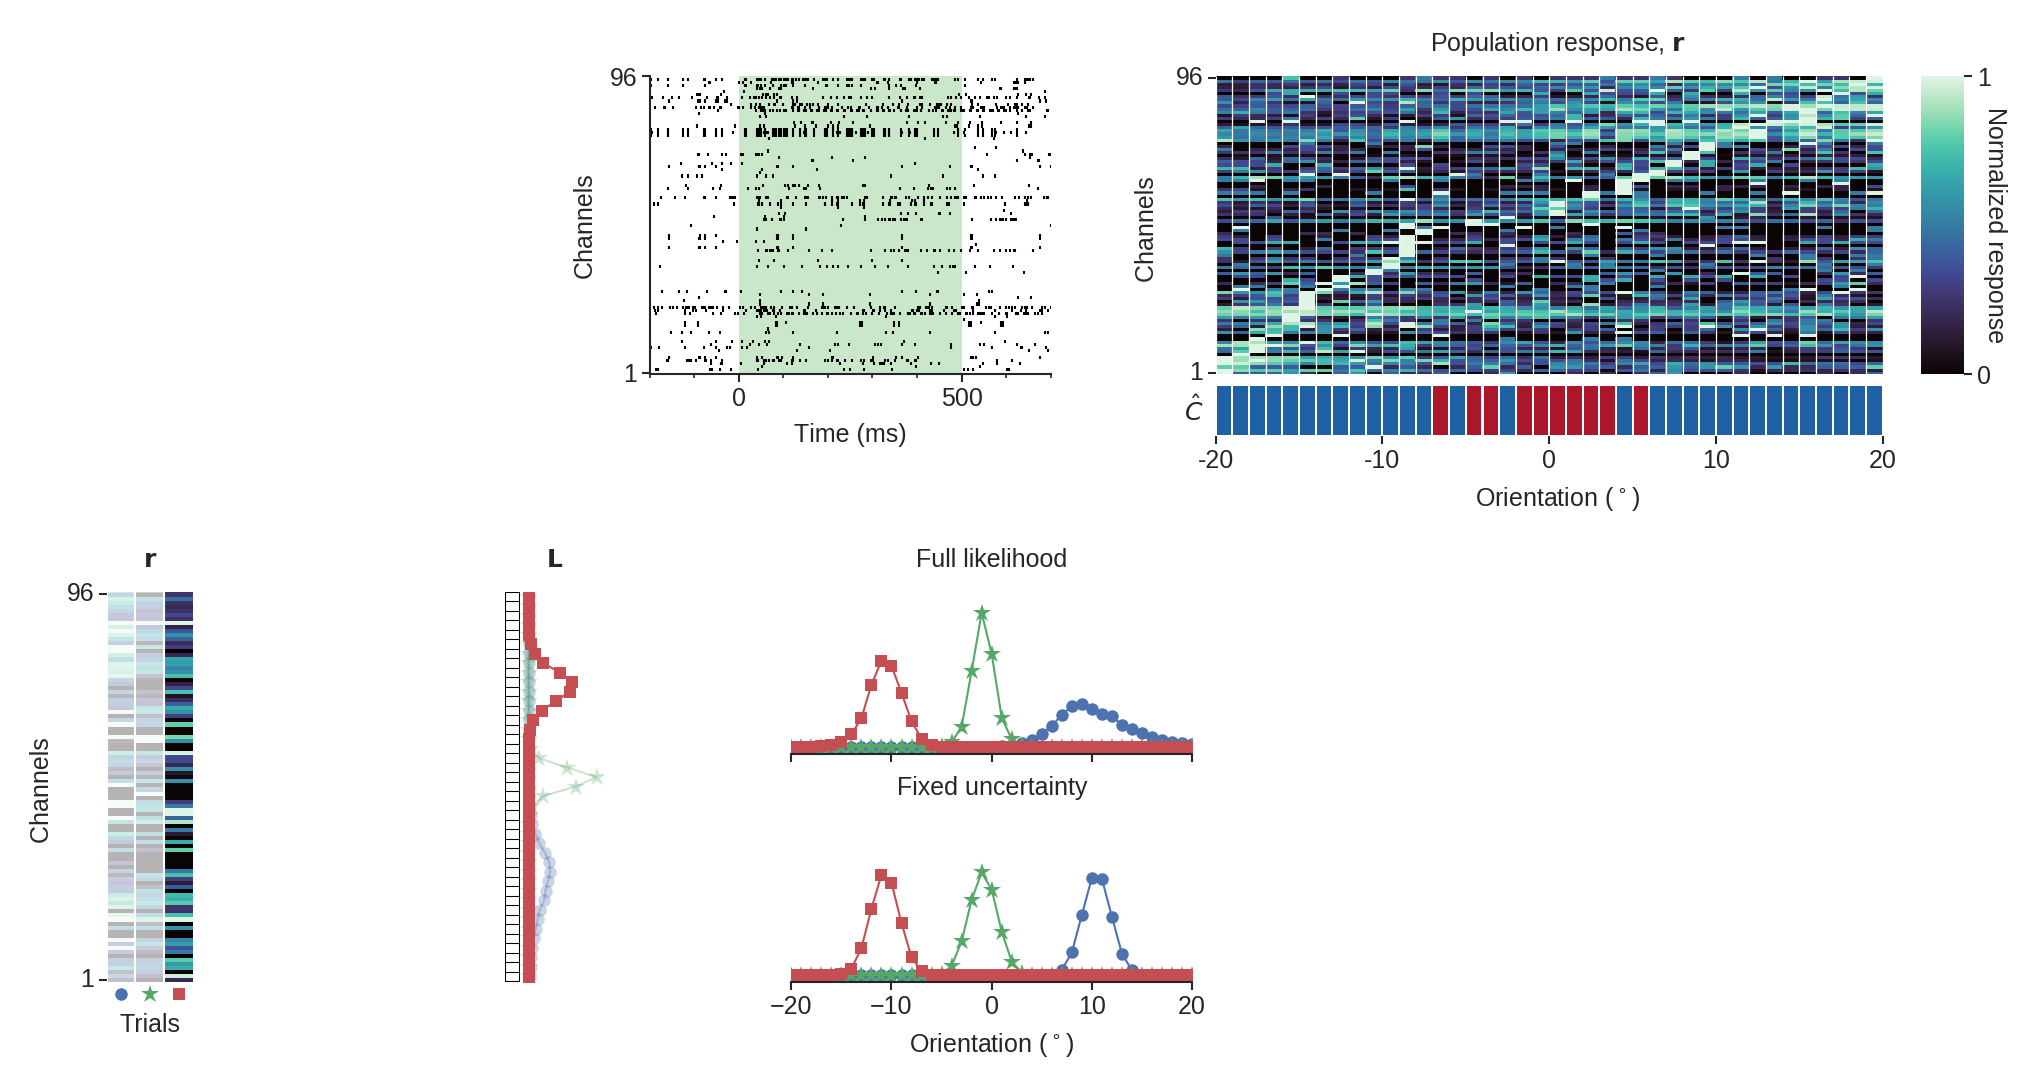

In [56]:
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

markers = ['o', '*', 's']
marker_sizes = [3, 4.5, 3]


fig = plt.figure(figsize=(7.2, 4), dpi=300)

bottom = 0.58
gs_top = gridspec.GridSpec(6, 12, bottom=bottom, hspace=hspace, wspace=wspace)
gs_right = gridspec.GridSpec(6, 1, bottom=bottom, left=0.91, right=0.93, hspace=hspace, wspace=wspace)

top = 0.45
gs_bottom = gridspec.GridSpec(7, 12, top=top, hspace=hspace, wspace=wspace)
#gs = gridspec.GridSpec(15, 12, hspace=hspace, wspace=wspace)
gs_left = gridspec.GridSpec(7, 1, top=top, left=0.07, right=0.11, hspace=hspace, wspace=wspace)
gs_outputs = gridspec.GridSpec(7, 2, top=top, left=0.2, right=0.3, hspace=hspace, wspace=wspace)

#gs_bottom = gridspec.GridSpec(1, 4, top=0.45, hspace=0.8, wspace=0.1)

gs_raster = gs_top[:5, 3:6]
gs_counts = gs_top[:5, 7:12]
gs_resp = gs_top[5, 7:12]
gs_counts_cbar = gs_right[:5, 0]


gs_rs = gs_left[:, 0]
gs_likelihoods = gs_bottom[0:3, 4:7]
gs_non_bayesian = gs_bottom[4:7, 4:7]

gs_readout = gs_outputs[:, 1]
gs_grids = gs_outputs[:, 0]

vline_color = [0.1, 0.1, 0.1]

#gs_model_resp = gs[8, 6:9]
#gs_class_cbar = gs_right[8, 0]



######### Counts plot ##############
ax, = add_subplots(gs_counts)
cax, = add_subplots(gs_counts_cbar)

counts = np.stack(trial_data['counts']).squeeze()
selection = trial_data['stimulus_class'] == 'A'
ori = trial_data['orientation'] - 270
pos = np.argsort(ori)
sorted_ori = ori[pos]

n_trials = 41
ori_crossing = np.arange(-20, 21)
oriticks = np.array([-20, -10, 0, 10, 20])
crossing_site = []
seed = 320 #np.random.randint(0, 1000)
print('Using seed {}'.format(seed))
np.random.seed(seed)
for v in binned_group(sorted_ori.ravel(), ori_crossing):
    crossing_site.append(np.random.choice(v[0]))
samples = pos[crossing_site]

filt = [0.25, 0.5, 0.25]
norm_counts = counts / (np.max(counts[samples], axis=0, keepdims=True) + 1e-5)
filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='same'), axis=0, arr=norm_counts[samples])
# ordering for channels
ordering = np.argsort(np.argmax(filtered, axis=0))

sns.heatmap(norm_counts[samples][:, ordering].T, cmap=sns.cm.mako, vmin=0, vmax=1.0, ax=ax, cbar=True, cbar_ax=cax, cbar_kws={'ticks':[0, 1.0]})
ax.vlines(np.arange(n_trials), *ax.get_ylim(), color='w', linewidth=0.3)

#cax = fig.axes[-1] # get colorbar axes that was just added
cax.set_ylabel('Normalized response', rotation=-90, fontsize=fs)
cax.tick_params(labelsize=fs, pad=pad)

ax.set_xlim(0, n_trials)
ax.set_ylim([0, 96])
ax.set_yticks([0.5, 95.5])
ax.set_yticklabels(['1', '96'], rotation=0, ha='right', va='center')
ax.set_xticks([])
ax.set_ylabel('Channels ', fontsize=fs)
ax.set_title(r'Population response, $\mathbf{r}$', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)

######## Response map #######
ax, = add_subplots(gs_resp)
cp = sns.color_palette("RdBu_r", 10)
sns.heatmap(selection[None, samples], square=False, vmax=1, vmin=0, cmap=cp, cbar=False, linewidth=0.25, ax=ax)

ax.set_xlim(0, n_trials)
ax.set_xticks(oriticks+20)
ax.set_xticklabels(oriticks, rotation=0)
ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)

ax.set_yticks([])
ax.set_ylabel(r"$\hat{C}$", fontsize=fs, rotation=0, verticalalignment='center', 
              labelpad=labelpad, horizontalalignment='right')
ax.tick_params(labelsize=fs, pad=pad)

####### Raster plot ##############
sns.set_palette('deep')
ax, = add_subplots(gs_raster)
    
ax.set_xticks([])
ax.set_yticks([])

trial_num = 4
spks = (ephys.SpikesAlignedTrial() &  trial_data[trial_num]).fetch('spikes_aligned', order_by='unit_id')

spks = spks[ordering]
for i, sp in enumerate(spks):
    ax.eventplot(np.atleast_1d(sp.squeeze().copy()), lineoffsets=i+1, linewidths=0.5, color='k')
    
ax.set_xticks([0, 500])
ax.set_xlabel('Time (ms)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Channels', fontsize=fs, labelpad=labelpad)
ax.set_xlim([-200, 700])
ax.set_ylim([0.5, 95.5])
ax.set_yticks([1, 96])
ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
ax.axvspan(0, 500, facecolor='#2ca02c', edgecolor=None, alpha=0.25)
sns.despine(offset=offset, ax=ax, trim=trim)
ax.tick_params(labelsize=fs, pad=pad)


######## Example counts to be decoded ########
ax, = add_subplots(gs_rs)
trials = [0, 4, 8]

sigma_trials = l_stats['sigma_likelihood'][trials]


ypos = -3
for i, m, ms in zip(count(), markers, marker_sizes):
    ax.plot(i+0.5, ypos, marker=m, ms=ms, clip_on=False)
sns.heatmap(norm_counts[trials][:, ordering].T, cmap=sns.cm.mako, vmin=0, vmax=1.0, ax=ax, cbar=False, cbar_kws={'ticks':[0, 1.0]})


# overlay gray map
ax.axvspan(0, 2, alpha=0.7, color=[1, 1, 1])
ax.vlines(np.arange(len(trials)), *ax.get_ylim(), color='w', linewidth=0.5)
ax.set_xlim(0, len(trials))
ax.set_xticks([])
ax.set_ylim([0, 96])
ax.set_yticks([0.5, 95.5])
ax.set_yticklabels(['1', '96'], rotation=0, ha='right', va='center')
ax.set_xlabel('Trials', fontsize=fs, labelpad=2.5*labelpad)
ax.set_ylabel('Channels ', fontsize=fs, labelpad=labelpad)
ax.set_title(r'$\mathbf{r}$', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)


####### Example decoded likelhoods from the NN #########
ax, = add_subplots(gs_readout)
sample_ori = np.arange(-30, 31).astype(float)
decode_ori = likelihood_data['decodeOri'].ravel() - 270

for idx, i, mk, ms in zip(count(), trials, markers, marker_sizes):
    L = likelihood_data['oldLikelihood'][:, i]
    f = interp1d(decode_ori, L, kind='quadratic')
    Ld = f(sample_ori)
    Ld /= Ld.sum()
    alpha = 1 if idx == len(trials)-1 else 0.3
    ax.plot(Ld, sample_ori, '-', marker=mk, ms=ms, linewidth=0.5, alpha=alpha)

patch_offset = 0.05
delta = np.diff(sample_ori).mean()
patch_width = 0.075
for ori in sample_ori:
#     p = patches.Rectangle((-x_scale, ori-delta/2), width=x_scale, height=delta, fill=True, color='b', edgecolor='k', linewidth=0.5)
    p = patches.Rectangle((-patch_width-patch_offset, ori-delta/2), patch_width, delta, fill=False,  edgecolor='k', linewidth=0.25)
    ax.add_patch(p)

ax.add_patch(p)
xlim = ax.get_xlim()
ax.set_xlim([- patch_width - patch_offset, 0.4])
ax.set_yticks([])
ax.set_xticks([])
#ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
ax.set_ylim([-20.5, 20.6])
ax.invert_yaxis()
ax.tick_params(labelsize=fs, pad=pad)
sns.despine(ax=ax, left=True, bottom=True)
ax.set_title(r'$\mathbf{L}$', fontsize=fs)

##### Readout likelihoods for full likelihood model ######
ax, = add_subplots(gs_likelihoods)
sample_ori = np.arange(-30, 31).astype(float)
decode_ori = likelihood_data['decodeOri'].ravel() - 270


for i, mk, ms in zip(trials, markers, marker_sizes):
    L = likelihood_data['oldLikelihood'][:, i]
    f = interp1d(decode_ori, L, kind='quadratic')
    Ld = f(sample_ori)
    Ld /= Ld.sum()
    ax.plot(sample_ori, Ld, '-', marker=mk, ms=ms, linewidth=0.5)
    
ax.set_yticks([])
ax.set_xticklabels([])
#ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
ax.set_xlim([-20, 20])
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1]*1.1])
sns.despine(ax=ax, trim=trim, offset=offset, left=True)
ax.set_title('Full likelihood', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)

##### Readout non-Bayesian approximated likelihoods #####
ax, = add_subplots(gs_non_bayesian)
sample_ori = np.arange(-30, 31).astype(float)
sigma = l_stats['mean_sigma']
sigma = l_stats['sigma_likelihood'][trials].mean()/2
peaks = likelihood_data['originalPeaks'].squeeze() - 270

for i, mk, ms in zip(trials, markers, marker_sizes):
    L = norm.pdf(sample_ori, loc=peaks[i], scale=sigma)
    L /= L.sum()
    ax.plot(sample_ori, L, '-', marker=mk, ms=ms, linewidth=0.5)
    
sns.despine(ax=ax, trim=trim, offset=offset, left=True)
ax.set_yticks([])
ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
#ax.set_ylabel('Likelihood (a.u.)', fontsize=fs, labelpad=labelpad)
ax.set_xlim([-20, 20])
ax.set_ylim([ylim[0], ylim[1]*1.1])
ax.set_title('Fixed uncertainty', fontsize=fs)
ax.tick_params(labelsize=fs, pad=pad)


# ## Model response map
# ax, = add_subplots(gs_model_resp)
# cax, = add_subplots(gs_class_cbar)
# cp = sns.color_palette("RdBu_r", 10)
# model_prespa = bayes_model_resp.presp_a
# sns.heatmap(model_prespa[None, samples], square=False, vmax=1, vmin=0, cmap=cp, cbar=True, cbar_ax=cax, 
#             cbar_kws={'ticks':[0,0.5, 1.0]}, linewidth=0.2, ax=ax)
# cax.tick_params(labelsize=fs)
# #cax.set_title(r"$P(\hat{C}=1)$", fontsize=fs)
# ax.set_yticks([])
# ax.set_xlim(0, n_trials)
# ax.set_xticks([])
# ax.set_ylabel(r"$P(\hat{C}=1)$", fontsize=fs, rotation=0, verticalalignment='center', horizontalalignment='right')
# ax.tick_params(labelsize=fs)
# ax.set_xticks(oriticks+20)
# ax.set_xticklabels(oriticks, rotation=0)
# ax.set_xlabel('Orientation ($^\circ$)', fontsize=fs)
# ax.xaxis.tick_top()

fig.savefig('figures/fig03.pdf')
fig.savefig('figures/fig03.png', dpi=200)

In [35]:
L = likelihood_data['oldLikelihood'][:, trials[0]]

In [36]:
mu = np.sum(decode_ori * L / np.sum(L, keepdims=True))

In [38]:
sigma = np.sqrt(np.sum(((decode_ori - mu)**2 * L) / np.sum(L, keepdims=True)))

In [39]:
sigma

3.372677746307548

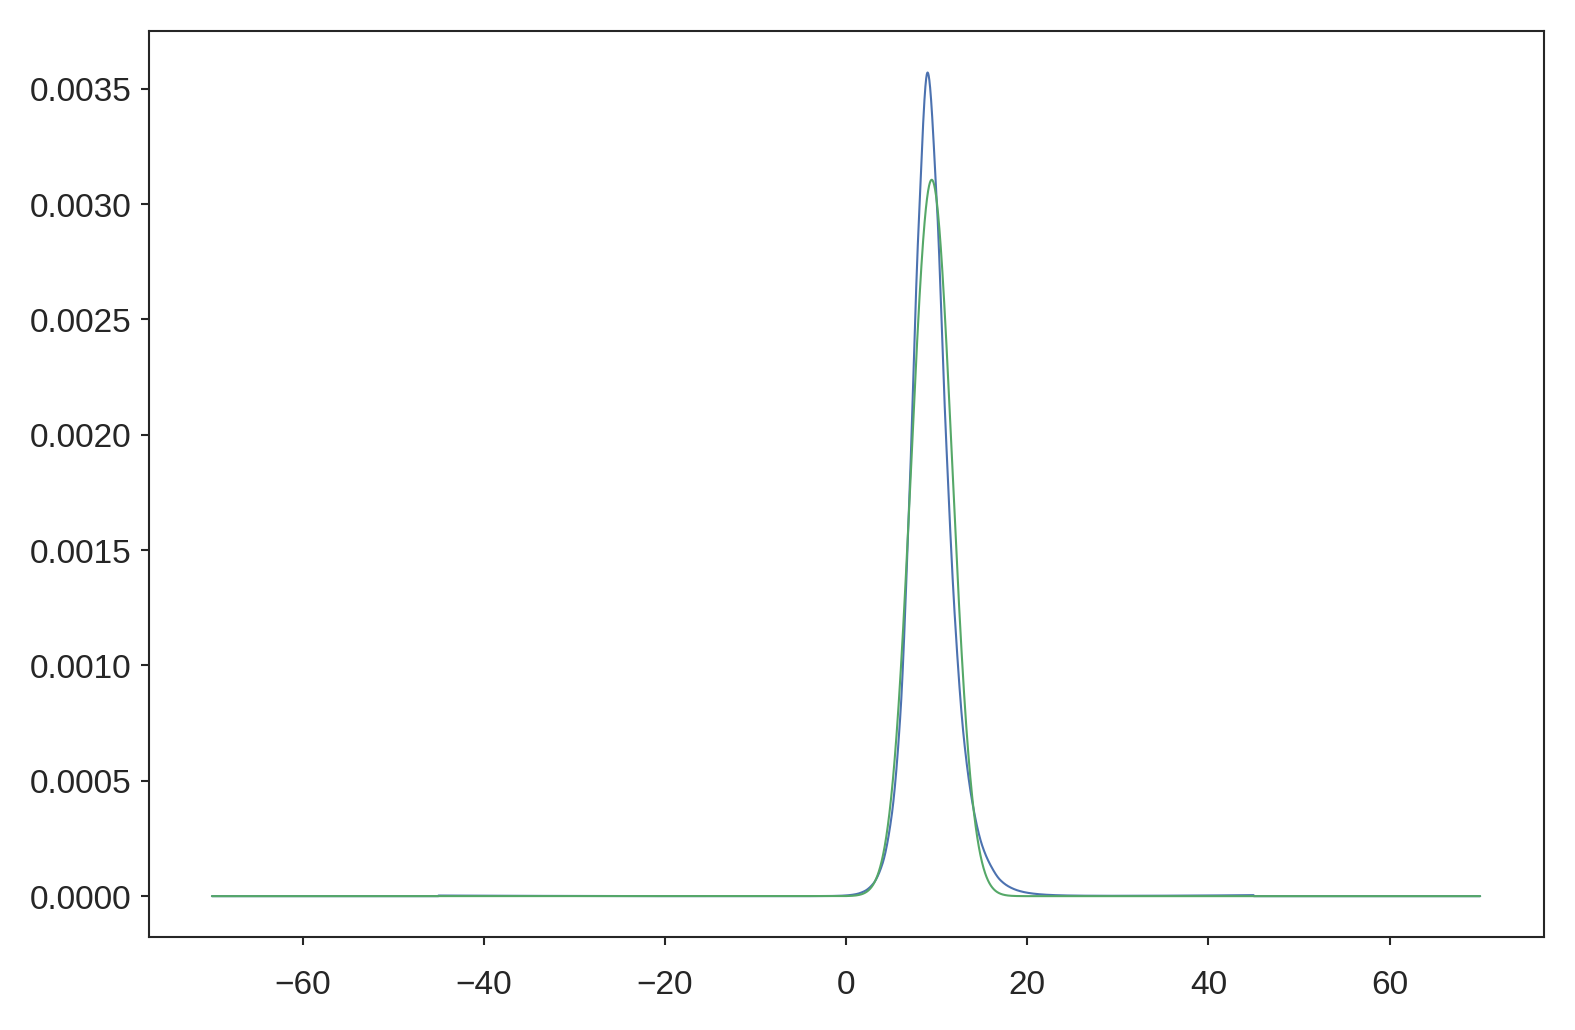

In [42]:
fig = plt.figure(dpi=300)
decode_ori = likelihood_data['decodeOri'].squeeze() - 270
Lg = norm.pdf(decode_ori, loc=mu, scale=sigma/1.5)
Lg = Lg / Lg.sum(keepdims=True)
Ln = L / L.sum(keepdims=True)
plt.plot(decode_ori, Ln)
plt.plot(decode_ori, Lg)



# Figure 3 - Likelihood functions

In [39]:
session_keys = (class_discrimination.CleanSpikeCountSet() & 'subject_id = 21' & 'total_trials_left > 3000').fetch('KEY')

session_key = session_keys[3] # good candidates 3

In [53]:
decoder_id = 3
lc_shuffle_id = 0
restr = dict(decoder_id=decoder_id, lc_shuffle_id=lc_shuffle_id)
header = class_discrimination.CleanSpikeCountSet * class_discrimination.CSCLookup * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash')
samples, cont, Lc = (analysis.LikelihoodSummary * analysis.LikelihoodStats * header & restr).fetch('samples', 'contrasts', 'ori_centered_likelihoods')

cont = np.concatenate(cont)
Lc = np.concatenate(Lc)

targets = analysis.LikelihoodSummary * header
keys = (targets & 'subject_id=21' & restr).fetch('KEY', order_by=','.join(targets.primary_key))
good_choices = [50, 87, 13] #[80, 50, 87, 13]

seed 91
0.14553427325704857
0.2508477791428364
0.44315622132496857


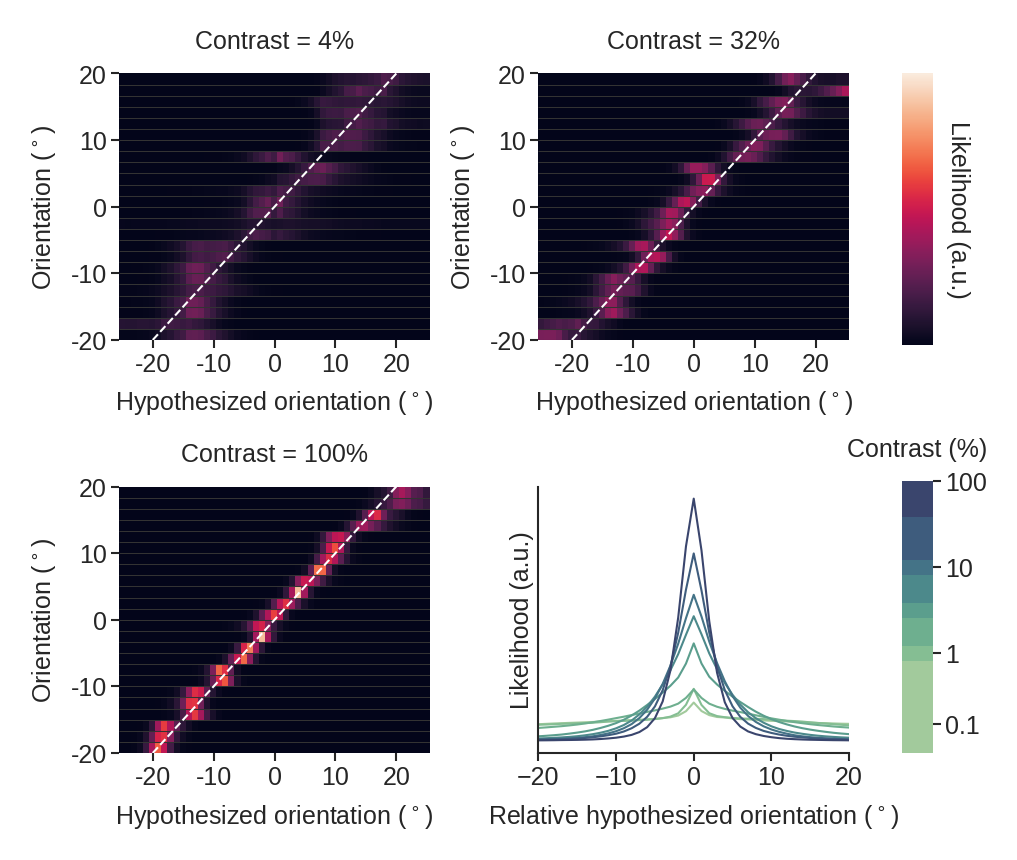

In [54]:
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
wspace=0.2
hspace=0.2


fig = plt.figure(figsize=(3.5, 3), dpi=300)

gs = gridspec.GridSpec(2, 2, wspace=0.35, hspace=0.55, right=0.82)
gs_right = gridspec.GridSpec(2, 1, left=0.87, right=0.90, hspace=0.5)

gs_example_cbar = gs_right[0, 0]
gs_summary_cbar = gs_right[1, 0]


extent = 20
ori_padding = 5
#fig, axs = plt.subplots(2, 2, figsize=(3.5, 3), dpi=300)
ori_edges = np.linspace(-extent, extent, 25)

slope = 1 / np.diff(ori_edges).mean()
ytick_vals = np.array([-20, -10, 0, 10, 20])
ytick_loc = (ytick_vals + extent) * slope

xtick_vals =[-20, -10, 0, 10, 20]

np.random.seed()
seed = np.random.randint(100)
seed = 91
print('seed', seed)
np.random.seed(seed)

cax, = add_subplots(gs_example_cbar)
for i, k, gse in zip(count(), good_choices, gs):
    ax, = add_subplots(gse)
    lk_info = (analysis.LikelihoodSummary * analysis.LikelihoodStats & keys[k]).fetch1()
    samples = lk_info['samples']
    sample_filter = (samples >= -extent-ori_padding) & (samples <= extent+ori_padding)
    ori_s = samples[sample_filter]
    ori_s_xloc = np.arange(len(ori_s)) + 0.5
    pos = np.isin(ori_s, xtick_vals)
    assert sum(pos) == len(xtick_vals), 'Missing tick locs'
    xtick_loc = ori_s_xloc[pos]
    ori = lk_info['orientation'] - 270
    L = lk_info['likelihoods'][:, sample_filter]
    L = L / L.sum(axis=1, keepdims=True)
    c = lk_info['contrast']

    Ls = []
    #np.random.seed(30)
    for g in binned_group(ori, ori_edges):
        if len(g[0]):
            pos = np.random.choice(g[0])
            Ls.append(L[pos])
        else:
            Ls.append(L[g].mean(axis=0))

    Lo = Ls
    Ls = np.stack(Ls)
    print(np.max(Ls))
    if i == 0:
        sns.heatmap(Ls, ax=ax, vmin=0, vmax=0.5, cbar=True, cbar_ax=cax, cbar_kws={'ticks':[]})
        cax.set_ylabel('Likelihood (a.u.)', rotation=-90, va='bottom', fontsize=fs, labelpad=labelpad)
        cax.tick_params(labelsize=fs, pad=pad)
    else:
        sns.heatmap(Ls, ax=ax, vmin=0, vmax=0.5, cbar=False)

    ori_d = np.linspace(-20, 20, 100)
    xv = (ori_d - xtick_vals[0]) * np.diff(xtick_loc)[0] / np.diff(xtick_vals)[0] + xtick_loc[0]
    yv = (ori_d - ytick_vals[0]) * np.diff(ytick_loc)[0] / np.diff(ytick_vals)[0] + ytick_loc[0]
    ax.plot(xv, yv, '--', color='w')
    ax.hlines(np.arange(Ls.shape[0]), *ax.get_xlim(), color=[0.2, 0.2, 0.2], linewidth=0.25)
    ax.set_title('Contrast = {:.0f}%'.format(c * 100), fontsize=fs)
    ax.invert_yaxis()
    ax.set_xlabel(r'Hypothesized orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
    ax.set_ylabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
    ax.set_xticks(xtick_loc)
    ax.set_xticklabels(xtick_vals, fontsize=fs, rotation=0, ha='center', va='top')
    ax.set_yticks(ytick_loc)
    ax.set_yticklabels(ytick_vals, fontsize=fs, rotation=0, ha='right')
    ax.tick_params(labelsize=fs, pad=pad)

# Likelihood summary plots
ax, = add_subplots(gs[1, 1])
cont_edges = np.percentile(cont, np.linspace(0, 100, 9))
Ls = []
for g in binned_group(cont, cont_edges):
    Ls.append(Lc[g].mean(axis=0))

Ls = np.stack(Ls)
Ln = Ls / Ls.sum(axis=1, keepdims=True)
colors = sns.cubehelix_palette(12, start=0.5, rot=-.75)[2:]
sns.set_palette(colors)
for i, Le, color in zip(count(), Ln, colors):
    ax.plot(samples, Le, label=i, color=color)
ax.set_xticks(xtick_vals)
ax.set_xlim([-20, 20])
ax.tick_params(labelsize=fs, pad=pad)
ax.set_xlabel(r'Relative hypothesized orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
ax.set_yticks([])
ax.set_ylabel('Likelihood (a.u.)', fontsize=fs, labelpad=pad)
sns.despine(ax=ax)

###### Add colorbar for the likelihood summary plot
ax, = add_subplots(gs_summary_cbar)
v = np.logspace(np.log10(0.0005), np.log(0.99), 20)[:, None]
cadj = cont_edges.copy()
pos = np.sum(v >= cont_edges, axis=1, keepdims=True)-1
pos[pos<0] = 0
tickloc = np.array([0.001, 0.01, 0.1, 1])
tickpos = np.argmin(np.abs(v - tickloc), axis=0)
sns.heatmap(pos, cmap=colors[:len(cont_edges)-1], vmin=-0.5, vmax=7.5, ax=ax, cbar=False)
ax.set_yticks(tickpos + 0.5)
ax.set_ylim([0.5, 19.5])
ax.set_yticklabels([0.1, 1, 10, 100], fontsize=fs, rotation=0)
ax.set_xticks([])
ax.set_title('Contrast (%)', fontsize=fs)
ax.yaxis.tick_right()
ax.tick_params(labelsize=fs, pad=pad)

#fig.tight_layout()

fig.savefig('figures/fig04.pdf')
fig.savefig('figures/fig04.png', dpi=200)

# Figure 5 - Shuffling analysis

Get data for both kinds of models and under both shuffled and non-shuffled conditions

In [50]:
decoder_id = 3
tom32 = get_summary(subject=21, model=32, decoder=decoder_id, shuffle=0)
tom32s = get_summary(subject=21, model=32, decoder=decoder_id, shuffle=1)
leo32 = get_summary(subject=3, model=32, decoder=decoder_id, shuffle=0)
leo32s = get_summary(subject=3, model=32, decoder=decoder_id, shuffle=1)
tom38 = get_summary(subject=21, model=38, decoder=decoder_id, shuffle=0)
tom38s = get_summary(subject=21, model=38, decoder=decoder_id, shuffle=1)
leo38 = get_summary(subject=3, model=38, decoder=decoder_id, shuffle=0)
leo38s = get_summary(subject=3, model=38, decoder=decoder_id, shuffle=1)

Also pick a particular session to demonstrate the dependency of the likelihood function on the stimulus orientation.

In [51]:
#session_key = {'csc_hash': '8b19498cf522fff44c6f14c2c6a33cc5955d18a7', 'dataset_contrast':'0.01'}
session_key = {'csc_hash': 'da82473ef9ed7a9774c6bcaea8c3bd28d5fcf1cc', 'dataset_contrast':'0.08'}
cvkey = (cd_dlset.CVSet * (cd_dataset.CleanContrastSessionDataSet & session_key).proj(dec_trainset_hash='dataset_hash')).fetch1('KEY')
non_shuffled_id = 0
shuffled_id = 1

data_path = (cd_dlset.DLSetInfo & cvkey & dict(decoder_id=decoder_id, lc_shuffle_id=shuffled_id)).fetch1('dataset_path')
likelihood_data = loadmat(data_path)['dataSet'][0, 0]

#sessions = class_discrimination.CSCLookup.fetch('KEY')
#session_key = sessions[82]

/src/v1_likelihood/v1_likelihood/utils.py:32: RuntimeWarning: Mean of empty slice
  mus = np.nanmean(assign * y, axis=1)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/src/v1_likelihood/v1_likelihood/utils.py:32: RuntimeWarning: Mean of empty slice
  mus = np.nanmean(assign * y, axis=1)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


64 [1 2 0]
Group 0 dof 110694
original Ttest_1sampResult(statistic=20.16300463370036, pvalue=3.0083628607328536e-90)
shuffled Ttest_1sampResult(statistic=-7.94706335648904, pvalue=1.9276689028164017e-15)
original-shuffled Ttest_1sampResult(statistic=22.249719684757338, pvalue=1.9752819475404754e-109)
Group 1 dof 192630
original Ttest_1sampResult(statistic=14.146706187221248, pvalue=2.062531915926088e-45)
shuffled Ttest_1sampResult(statistic=-8.488518457680039, pvalue=2.1074178898913402e-17)
original-shuffled Ttest_1sampResult(statistic=18.571761686782203, pvalue=6.351407060869497e-77)


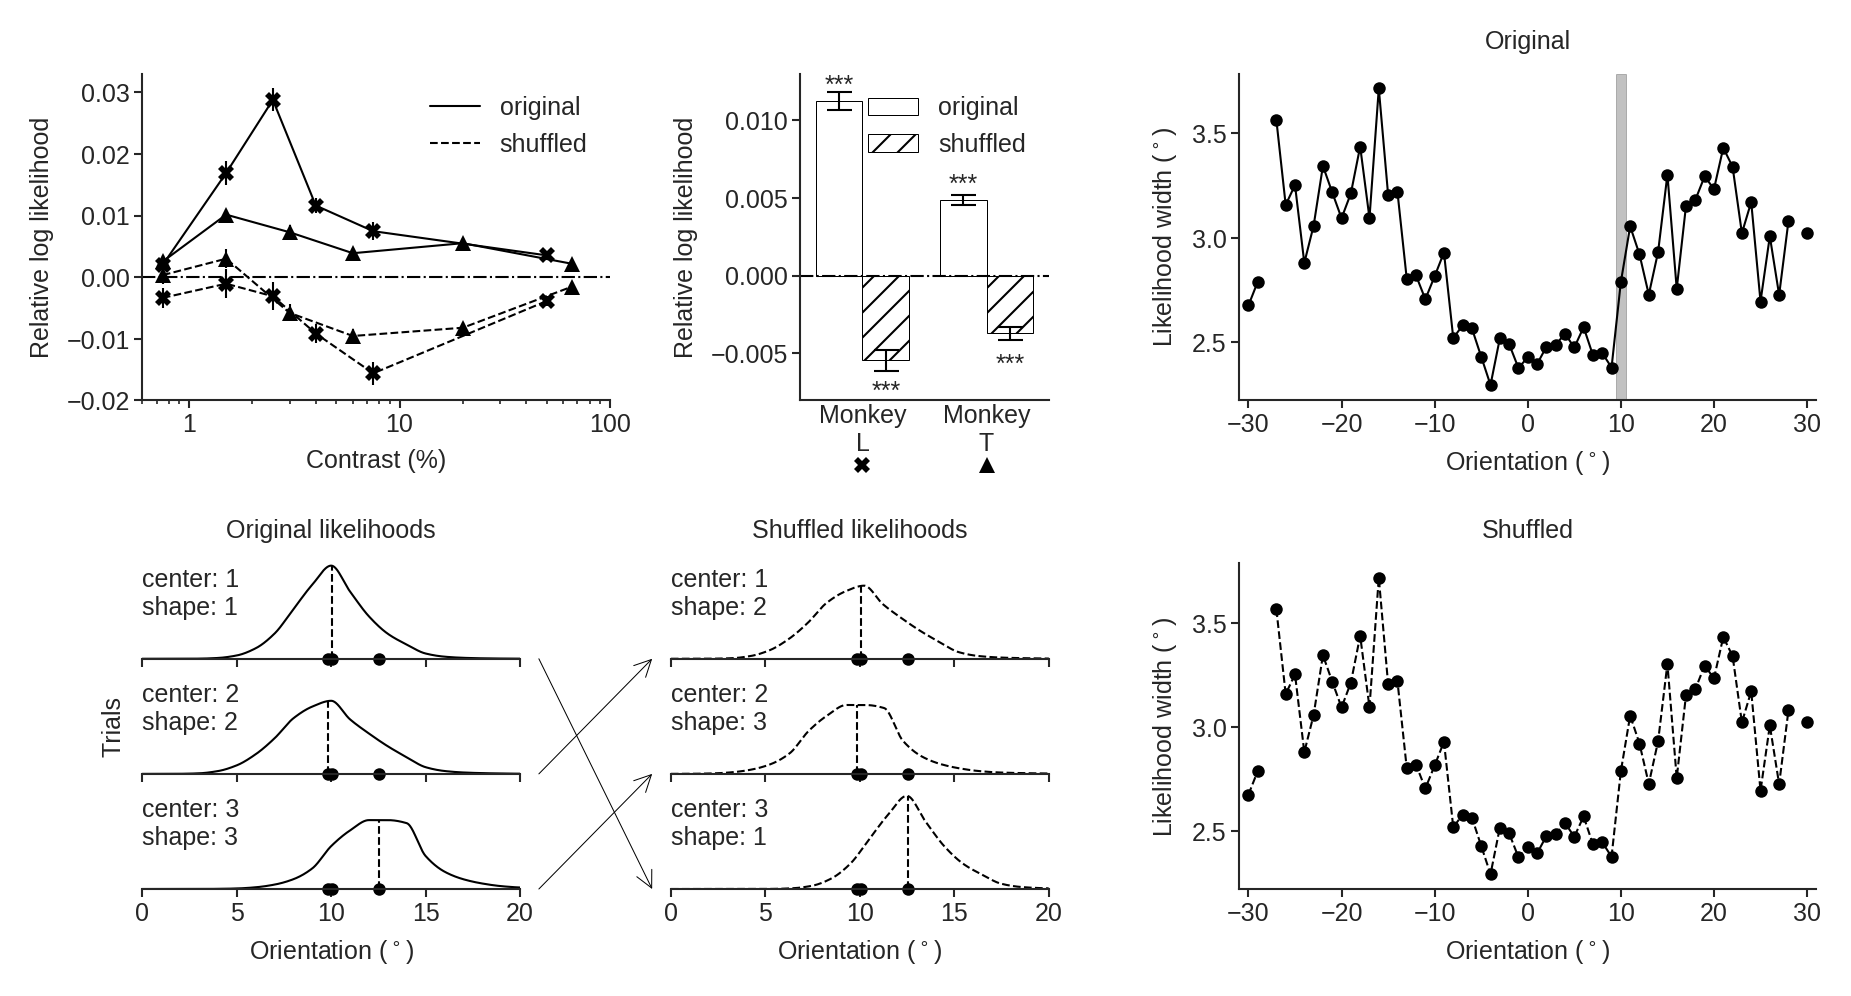

In [52]:
fs = 6.0
fs_inset = 5.0
offset = 0
trim = False
marker_size=3
pad = 1
labelpad=3

sample_ori = 10
sample_shade = np.array([1, 1, 1]) * 0.2

pos = (likelihood_data['orientationBin'] -270 == sample_ori).squeeze()
decode_ori = (likelihood_data['decodeOri'] - 270).squeeze()
L = likelihood_data['oldLikelihood'][:, pos].T
peaks = likelihood_data['originalPeaks'][0, pos].squeeze()

capsize=3

original_color = 'k'#xkcd:turquoise'
shuffled_color = 'k'#xkcd:light orange'
original_style = '-'
shuffled_style = '--'


# get likelihood data

fig = plt.figure(figsize=(7.2, 3.6), dpi=300)
gs = gridspec.GridSpec(2, 16, wspace=2.8, hspace=0.5)



gs_delta_logl = gs[0, :5]
gs_bar = gs[0, 6:9]
gs_shuffling = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1, :9], wspace=0.4)


gs_lwidth_original = gs[0, 10:]
gs_lwidth_shuffled = gs[1, 10:]


##### Likelihood width vs stimulus orientation [ORIGINAL] ############
sns.set_palette('deep')
ax, = add_subplots(gs_lwidth_original)

# sort by the contrast
ori_edges = np.arange(-30.5, 31, step=1)
contrast = float(cvkey['dataset_contrast'])
ls_stats = (LikelihoodStats & cvkey & dict(decoder_id=decoder_id, lc_shuffle_id=non_shuffled_id)).fetch1()
# note that we need to use the parameters from the shuffled_id condition
binw, binc = (cd_dlset.ShuffleParam() & dict(decoder_id=decoder_id, lc_shuffle_id=shuffled_id)).fetch1('bin_width', 'bin_center')

ori_bin = (np.round((ls_stats['orientation'] - binc) / binw) * binw + binc).astype(int)
unique_bins = np.unique(ori_bin)
sieve = (unique_bins[:, None] == ori_bin)
bin_counts = np.sum(sieve, axis=1)
ubin = unique_bins.astype(float) - 270
sp = np.sum(sieve * ls_stats['sigma_likelihood'], axis=1) / bin_counts
stats = binned_stats(ubin, sp, ori_edges)

# plot the binned width vs stimulus orientation
ax.errorbar(stats.binc, stats.mu, stats.sem, marker='o', linestyle=original_style, ms=3, label=contrast, color=original_color)
ax.axvspan(sample_ori - binw/2, sample_ori + binw/2, color=sample_shade, alpha=0.3)

ax.set_xlim([-31, 31])
ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel(r'Likelihood width ($^\circ$)', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
ax.set_title('Original', fontsize=fs)


##### Likelihood width vs stimulus orientation [SHUFFLED] ############
sns.set_palette('deep')
ax, = add_subplots(gs_lwidth_shuffled)

cvkey = (cd_dlset.CVSet * (cd_dataset.CleanContrastSessionDataSet & session_key).proj(dec_trainset_hash='dataset_hash')).fetch1('KEY')

# sort by the contrast
contrast = float(cvkey['dataset_contrast'])
ls_stats = (LikelihoodStats & cvkey & dict(decoder_id=decoder_id, lc_shuffle_id=shuffled_id)).fetch1()
binw, binc = (cd_dlset.ShuffleParam() & dict(decoder_id=decoder_id, lc_shuffle_id=shuffled_id)).fetch1('bin_width', 'bin_center')

ori_bin = (np.round((ls_stats['orientation'] - binc) / binw) * binw + binc).astype(int)
unique_bins = np.unique(ori_bin)
sieve = (unique_bins[:, None] == ori_bin)
bin_counts = np.sum(sieve, axis=1)
ubin = unique_bins.astype(float) - 270
sp = np.sum(sieve * ls_stats['sigma_likelihood'], axis=1) / bin_counts
stats = binned_stats(ubin, sp, ori_edges)

# plot the binned width vs stimulus orientation
ax.errorbar(stats.binc, stats.mu, stats.sem, marker='o', ms=3, linestyle=shuffled_style, label=contrast, color=shuffled_color)

ax.set_xlim([-31, 31])
ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel(r'Likelihood width ($^\circ$)', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
ax.set_title('Shuffled', fontsize=fs)


########## Likelihood examples before and after shuffling ##############

samples = [0, 2, 9]
L_samples = L[samples]
Lmax = L_samples.max() * 1.03
peak_original = peaks[samples] - 270

seed = 64
#seed = np.random.randint(100)
np.random.seed(seed)
shuffle_pos = np.random.permutation(len(samples))
print(seed, shuffle_pos)
shuffled_L = L_samples[shuffle_pos]

peak_shuffled = peak_original[shuffle_pos]
peak_shift = peak_original - peak_shuffled

colors = ['k','k','k']
labels_original = ['center: {}\nshape: {}'.format(i+1, i+1) for i in range(len(samples))]
labels_shuffled = ['center: {}\nshape: {}'.format(i+1, j+1) for i, j in enumerate(shuffle_pos)]


ax_original = []
for i, Ls, pko, color, label in zip(count(), L_samples, peak_original, colors, labels_original):
    ax, = add_subplots(gs_shuffling[i, 0])
    ax_original.append(ax)
    L_peak = Ls[np.argmin(np.abs(decode_ori-pko))]
    ax.plot(decode_ori, Ls, color=color)
    ax.vlines(pko, 0, L_peak, linestyles='--', colors=color)
    ax.set_xlim([sample_ori-10, sample_ori+10])
    ax.set_ylim([0, Lmax])
    ax.set_yticks([])
    if i == 0:
        ax.set_title('Original likelihoods', fontsize=fs)
        
    if i == len(L_samples)-1:
        ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
    else:
        ax.set_xticklabels([])
        
    ax.text(0, 0.95, label, fontsize=fs, transform=ax.transAxes, ha='left', va='top')
        
    if i == 1:
        ax.set_ylabel('Trials', fontsize=fs)
    sns.despine(ax=ax, trim=trim, offset=offset, left=True)
    ax.tick_params(labelsize=fs, pad=pad)
    
    for x, c in zip(peak_original, colors):
        ax.plot(x, 0, ms=3, marker='o', clip_on=False, color=c)


ax_shuffle = []
for i, shift, Lo, Ls, pko, color, label in zip(count(), peak_shift, L_samples, shuffled_L, peak_original, colors, labels_shuffled):
    ax, = add_subplots(gs_shuffling[i, 1])
    ax_shuffle.append(ax)
    L_peak = Ls[np.argmin(np.abs(decode_ori-(pko-shift)))]
    #ax.plot(decode_ori, Lo, linestyle='--', color=original_color)
    #print(shift)
    ax.plot(decode_ori + shift, Ls, linestyle='--', color=color)
    ax.vlines(pko, 0, L_peak, linestyles='--', colors=color)
    ax.set_xlim([sample_ori-10, sample_ori+10])
    ax.set_ylim([0, Lmax])
    ax.set_yticks([])
    if i == 0:
        ax.set_title('Shuffled likelihoods', fontsize=fs)
    if i == len(L_samples)-1:
        ax.set_xlabel(r'Orientation ($^\circ$)', fontsize=fs, labelpad=labelpad)
    else:
        ax.set_xticklabels([])
        
    ax.text(0, 0.95, label, fontsize=fs, transform=ax.transAxes, ha='left', va='top')
        
    for x, c in zip(peak_original, colors):
        ax.plot(x, 0, ms=3, marker='o', clip_on=False, color=c)
        
        

        
    sns.despine(ax=ax, trim=trim, offset=offset, left=True)
    ax.tick_params(labelsize=fs, pad=pad)
ax_original = np.array(ax_original)

ax_original = ax_original[shuffle_pos]

# add arrows connecting original to shuffled
for axo, axs in zip(ax_original, ax_shuffle):
    con = ConnectionPatch(xyA=(1.05, 0), xyB=(-0.05, 0), coordsA='axes fraction', coordsB='axes fraction',
                      axesA=axo, axesB=axs,
                      arrowstyle="->")
    axs.add_artist(con)



########## Delta log likelihood vs contrast relative to fixed-uncertainty model ##############
ax, = add_subplots(gs_delta_logl)
summary_pairs = [(leo32, leo38), (leo32s, leo38s), (tom32, tom38),  (tom32s, tom38s),]
markers = [leo_marker, leo_marker, tom_marker, tom_marker]
marker_sizes = [4, 4, 4, 4]
colors = [original_color, shuffled_color] * 2
linestyles=[original_style, shuffled_style, original_style, shuffled_style]


for (m1, m2), marker, ms, color, ls in zip(summary_pairs, markers, marker_sizes, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, delta_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, ms=ms, color=color, linestyle=ls)

ax.axhline(0, linestyle='-.', color='k')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
#ax.set_ylim([45, 100])
#ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
ax.set_ylim(ax.get_ylim())
x = [0, 1]
y = [1, 1]
ax.plot(x, y, '-k', label='original')
ax.plot(x, y, '--k', label='shuffled')
ax.legend(fontsize=fs)
#ax.minorticks_off()


## Delta log likelihood bar plot relative to non-Bayesian
ax, = add_subplots(gs_bar)
summary_pairs = [(leo32, leo38, leo32s, leo38s), (tom32, tom38, tom32s, tom38s),]
markers = [leo_marker, tom_marker]
colors = [(original_color, shuffled_color), (original_color, shuffled_color)]
group_labels = ['Monkey\nL', 'Monkey\nT']

bar_spacing = 0.8
bar_width = 0.3
bar_centers = np.arange(len(summary_pairs)) * bar_spacing
for i, bc, (m1, m1b, m2, m2b), marker, (c1, c2) in zip(count(), bar_centers, summary_pairs, markers, colors):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m1b_test_logl = np.concatenate(m1b['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    m2b_test_logl = np.concatenate(m2b['test_logl']).squeeze()
    delta1_logl = m1_test_logl - m1b_test_logl
    delta2_logl = m2_test_logl - m2b_test_logl
    delta12_logl = m1_test_logl - m2_test_logl
    
    
    res1 = ttest_1samp(delta1_logl, 0)
    res2 = ttest_1samp(delta2_logl, 0)
    res12 = ttest_1samp(delta12_logl, 0)
    print('Group {}'.format(i), 'dof', len(delta1_logl)-1)
    print('original', res1)
    print('shuffled', res2)
    print('original-shuffled', res12)
    
    textshift = 0.0005
    star_offset = 1.5e-3
    mu1 = delta1_logl.mean()
    barc = bc - bar_width/2
    
    lbl = 'original' if i==0 else None
    ax.bar(barc, mu1, bar_width, color=c1, facecolor='w', edgecolor=c1, label=lbl)

    sem1 = delta1_logl.std() / np.sqrt(len(delta1_logl))
    ax.errorbar(barc, mu1, sem1, fmt='none', capsize=capsize, capthick=0.5, color=c1,)
    label = significance_indicator(res1.pvalue)
    if label:
        ax.text(barc, mu1 + np.sign(mu1) * star_offset - textshift, label, ha='center', va='center', fontsize=fs)
    
    mu2 = delta2_logl.mean()
    barc = bc + bar_width/2
    sem2 = delta2_logl.std() / np.sqrt(len(delta2_logl))
    ax.errorbar(barc, mu2, sem2, fmt='none', capsize=capsize, capthick=0.5, color=c2,)
    lbl = 'shuffled' if i==0 else None
    bars = ax.bar(barc, mu2, bar_width, edgecolor=c2, facecolor='w', label=lbl)
    bars[0].set_hatch('////')
    
    label = significance_indicator(res2.pvalue)
    if label:
        ax.text(barc, mu2 + np.sign(mu2) * star_offset - textshift, label, ha='center', va='center', fontsize=fs)
    # plot the marker below the xlabel
    trans = transforms.blended_transform_factory(
        ax.transData, ax.transAxes)
    ax.plot(bc, -0.2, transform=trans, color='k', marker=marker, ms=4, clip_on=False)
ax.axhline(0, linestyle='-.', color='k')

    
ax.set_xticks(bar_centers)
ax.set_xticklabels(group_labels)
ax.set_xlim([bar_centers[0] - bar_spacing/2, bar_centers[-1] + bar_spacing/2])
ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
ax.set_ylim([-0.008, 0.013])
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)
ax.tick_params(axis='x', length=0)
ax.legend(fontsize=fs, loc='upper right')

fig.savefig('figures/fig05.pdf')
fig.savefig('figures/fig05.png', dpi=200)

# Figure Extra - Model performance

Get data for each subject and for two models. 

* model 32 - Full likelihood model
* model 38 - Fixed uncertainty model

In [27]:
decoder_id = 3
tom32 = get_summary(subject=21, model=32, decoder=decoder_id, shuffle=0)
tom38 = get_summary(subject=21, model=45, decoder=decoder_id, shuffle=0)
leo32 = get_summary(subject=3, model=32, decoder=decoder_id, shuffle=0)
leo38 = get_summary(subject=3, model=45, decoder=decoder_id, shuffle=0)

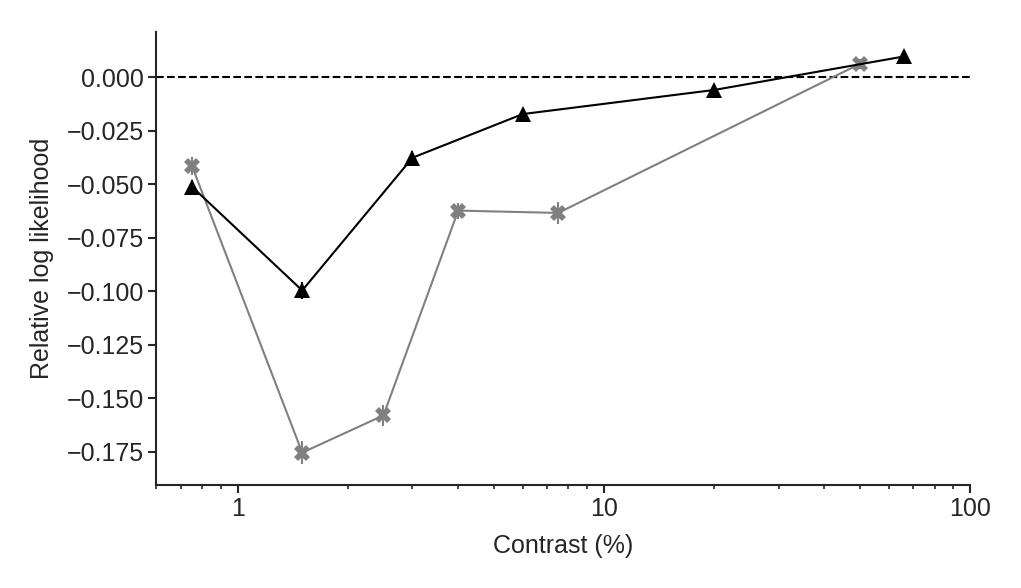

In [28]:
marker_size=4
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

fig = plt.figure(figsize=(3.5, 2), dpi=300)
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.5)
gs_bar = gridspec.GridSpec(1, 1, left=0.55, right=0.85, bottom=0.55, top=0.85)

gs_delta_logl = gs[0, 0]
gs_bar_delta = gs_bar[0, 0]


######## Delta log likelihood vs contrast ########
ax, = add_subplots(gs_delta_logl)
summary_pairs = [(leo32, leo38), (tom32, tom38)]
markers = [leo_marker, '^']
linestyles=['-', '-']
colors = [leo_color, tom_color]

deltas = []
for (m1, m2), marker, color, ls in zip(summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    deltas.append(delta_logl)
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, delta_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(0, linestyle='--', color='k')
ax.set_xscale('log')
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)

# ###### Delta log likelihood bar plot #######
# ax, = add_subplots(gs_bar_delta)
# summary_pairs = [(leo32, leo38), (tom32, tom38),]
# markers = [leo_marker, tom_marker]
# colors = [leo_color, tom_color]
# group_labels = ['Monkey L', 'Monkey T']

# for i, (m1, m2), marker, color, ls in zip(count(), summary_pairs, markers, colors, linestyles):
#     contrasts = np.concatenate(m1['cont_vals']).squeeze()
#     m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
#     m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
#     delta_logl = m1_test_logl - m2_test_logl
#     res = ttest_rel(m1_test_logl, m2_test_logl)
#     mu = delta_logl.mean()
#     ax.bar(i, mu, 0.5, color=color)
#     sem = delta_logl.std() / np.sqrt(len(delta_logl))
#     ax.errorbar(i, mu, sem, fmt='none', capsize=5, capthick=0.5, color=color,)
#     # plot the markers
#     ax.plot(i, -0.003, marker=marker, ms=marker_size, color=color, clip_on=False)
#     label = significance_indicator(res.pvalue)
#     if label:
#         ax.text(i, mu + 1.5*sem, label, horizontalalignment='center', verticalalignment='center', fontsize=fs)
        
# ax.set_xticks([0, 1])
# ax.set_xticklabels(group_labels)
# ax.set_xlim([-0.5, 1.5])

# ax.set_ylim([0, 0.013])
# ax.set_yticks([0, 0.005, 0.01])
# ax.set_yticklabels(['0', '0.005', '0.01'])
# ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
# sns.despine(ax=ax, trim=trim, offset=offset)
# ax.tick_params(labelsize=fs, pad=pad)
# ax.tick_params(axis='x', length=0) # just suppress ticks


fig.savefig('figures/fig04x.pdf')
fig.savefig('figures/fig04x.png', dpi=200)
#ax.minorticks_off()

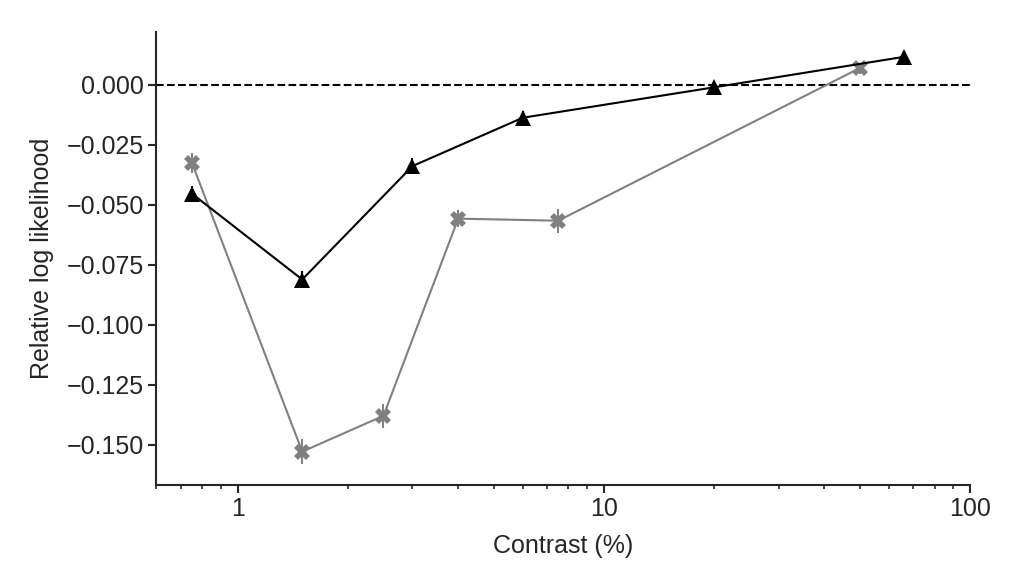

In [26]:
marker_size=4
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

fig = plt.figure(figsize=(3.5, 2), dpi=300)
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.5)
gs_bar = gridspec.GridSpec(1, 1, left=0.55, right=0.85, bottom=0.55, top=0.85)

gs_delta_logl = gs[0, 0]
gs_bar_delta = gs_bar[0, 0]


######## Delta log likelihood vs contrast ########
ax, = add_subplots(gs_delta_logl)
summary_pairs = [(leo32, leo38), (tom32, tom38)]
markers = [leo_marker, '^']
linestyles=['-', '-']
colors = [leo_color, tom_color]

deltas = []
for (m1, m2), marker, color, ls in zip(summary_pairs, markers, colors, linestyles):
    contrasts = np.concatenate(m1['cont_vals']).squeeze()
    m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
    m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
    delta_logl = m1_test_logl - m2_test_logl
    deltas.append(delta_logl)
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, delta_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(0, linestyle='--', color='k')
ax.set_xscale('log')
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlabel('Contrast (%)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs, pad=pad)

# ###### Delta log likelihood bar plot #######
# ax, = add_subplots(gs_bar_delta)
# summary_pairs = [(leo32, leo38), (tom32, tom38),]
# markers = [leo_marker, tom_marker]
# colors = [leo_color, tom_color]
# group_labels = ['Monkey L', 'Monkey T']

# for i, (m1, m2), marker, color, ls in zip(count(), summary_pairs, markers, colors, linestyles):
#     contrasts = np.concatenate(m1['cont_vals']).squeeze()
#     m1_test_logl = np.concatenate(m1['test_logl']).squeeze()
#     m2_test_logl = np.concatenate(m2['test_logl']).squeeze()
#     delta_logl = m1_test_logl - m2_test_logl
#     res = ttest_rel(m1_test_logl, m2_test_logl)
#     mu = delta_logl.mean()
#     ax.bar(i, mu, 0.5, color=color)
#     sem = delta_logl.std() / np.sqrt(len(delta_logl))
#     ax.errorbar(i, mu, sem, fmt='none', capsize=5, capthick=0.5, color=color,)
#     # plot the markers
#     ax.plot(i, -0.003, marker=marker, ms=marker_size, color=color, clip_on=False)
#     label = significance_indicator(res.pvalue)
#     if label:
#         ax.text(i, mu + 1.5*sem, label, horizontalalignment='center', verticalalignment='center', fontsize=fs)
        
# ax.set_xticks([0, 1])
# ax.set_xticklabels(group_labels)
# ax.set_xlim([-0.5, 1.5])

# ax.set_ylim([0, 0.013])
# ax.set_yticks([0, 0.005, 0.01])
# ax.set_yticklabels(['0', '0.005', '0.01'])
# ax.set_ylabel('Relative log likelihood', fontsize=fs, labelpad=labelpad)
# sns.despine(ax=ax, trim=trim, offset=offset)
# ax.tick_params(labelsize=fs, pad=pad)
# ax.tick_params(axis='x', length=0) # just suppress ticks


fig.savefig('figures/fig04x.pdf')
fig.savefig('figures/fig04x.png', dpi=200)
#ax.minorticks_off()

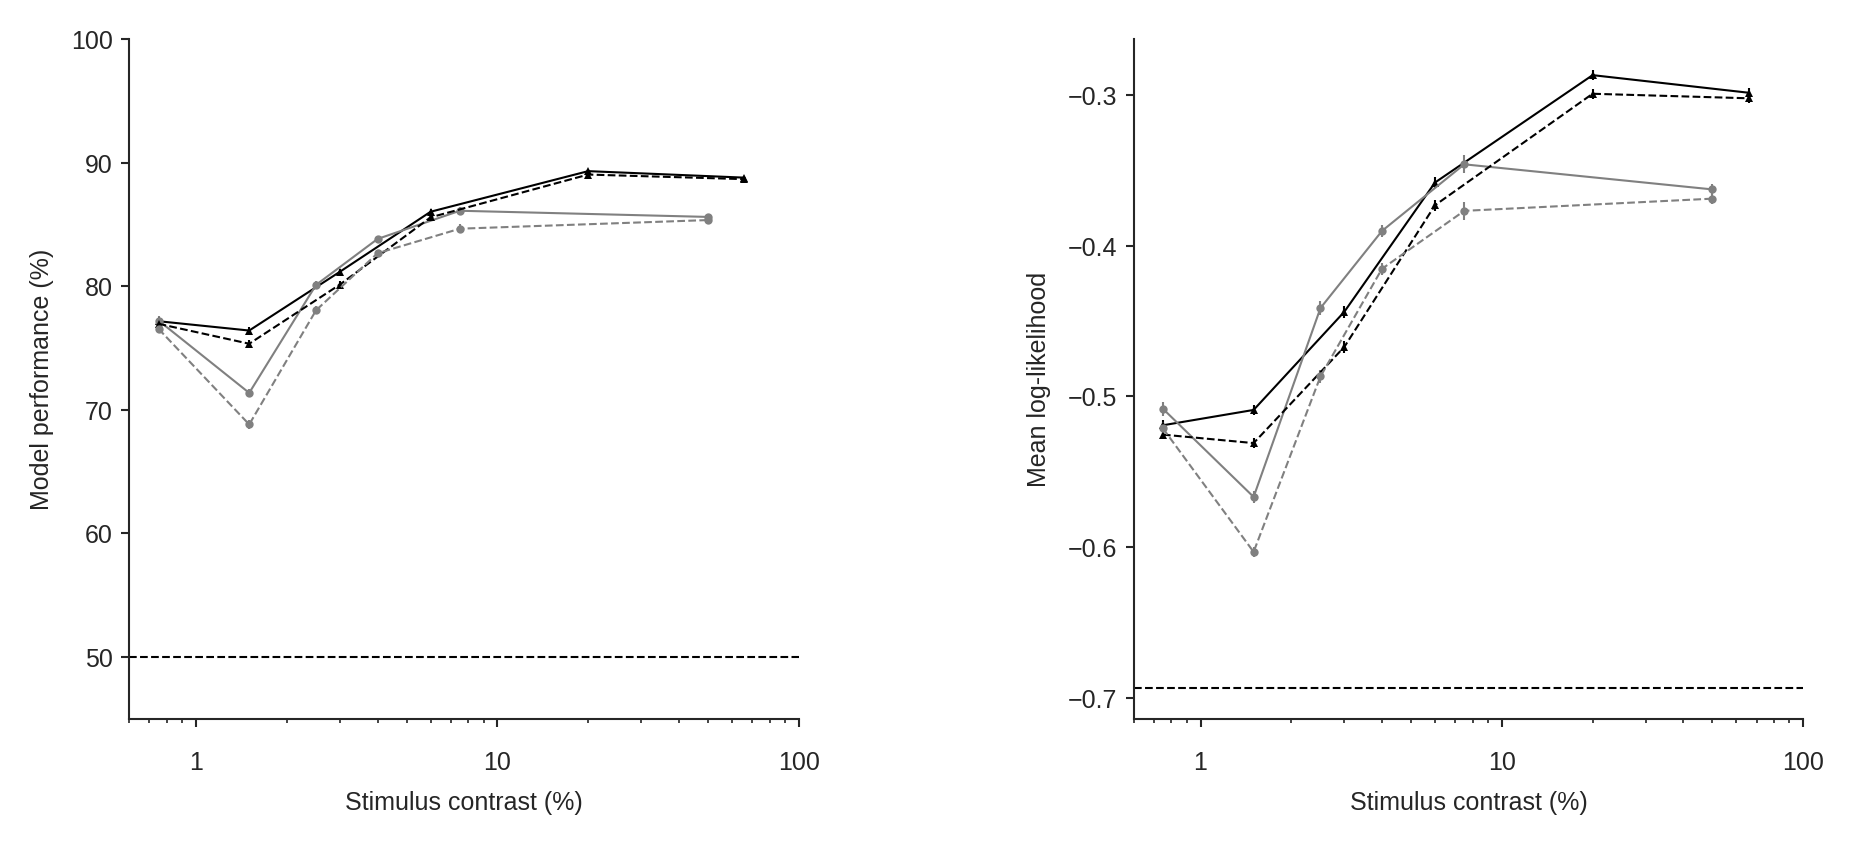

In [140]:
fs = 6.0
offset = 0
trim = False
marker_size=2
pad = 1
labelpad=3
wspace=0.2
hspace=0.2

fig = plt.figure(figsize=(7.2, 3), dpi=300)
gs = gridspec.GridSpec(1, 2, wspace=0.5, hspace=0.5)

gs_correct = gs[0, 0]
gs_mean_logl = gs[0, 1]


################ Performance vs contrast #####################
ax, = add_subplots(gs_correct)
summary_sets = [tom32, leo32, tom38, leo38]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    correct_resp = np.concatenate(summary_set['correct_resp']).squeeze() * 100
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, correct_resp, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(50, linestyle='--', color='k')

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
ax.set_ylim([45, 100])
ax.set_yticks([50, 60, 70, 80, 90, 100])
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Model performance (%)', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)
#ax.minorticks_off()

########## Mean log likelihood vs contrast #####################
ax, = add_subplots(gs_mean_logl)
summary_sets = [tom32, leo32, tom38, leo38]
markers = ['^', 'o'] * 2
linestyles=['-', '-', '--', '--']
colors = [tom_color, leo_color] * 2

for summary_set, marker, color, ls in zip(summary_sets, markers, colors, linestyles):
    contrasts = np.concatenate(summary_set['cont_vals']).squeeze()
    test_logl = np.concatenate(summary_set['test_logl']).squeeze() 
    cont_edges = np.percentile(contrasts, np.linspace(0, 100, 7))
    stats = binned_stats(contrasts, test_logl, cont_edges)
    ax.errorbar(stats.binc, stats.mu, stats.sem, marker=marker, linestyle=ls, ms=marker_size, color=color)

ax.axhline(np.log(0.5), linestyle='--', color='k')

ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1])
ax.set_xticklabels(['1', '10', '100'])
ax.set_xlim((ax.get_xlim()[0], 1))
tx=ax.set_xlabel('Stimulus contrast (%)', fontsize=fs)
ax.set_ylabel('Mean log-likelihood', fontsize=fs)
#ax.legend(fontsize=fs, loc=(.5, 0.28))
sns.despine(ax=ax, trim=trim, offset=offset)
ax.tick_params(labelsize=fs)


fig.savefig('figures/ext_fig01.pdf')
#ax.minorticks_off()

3


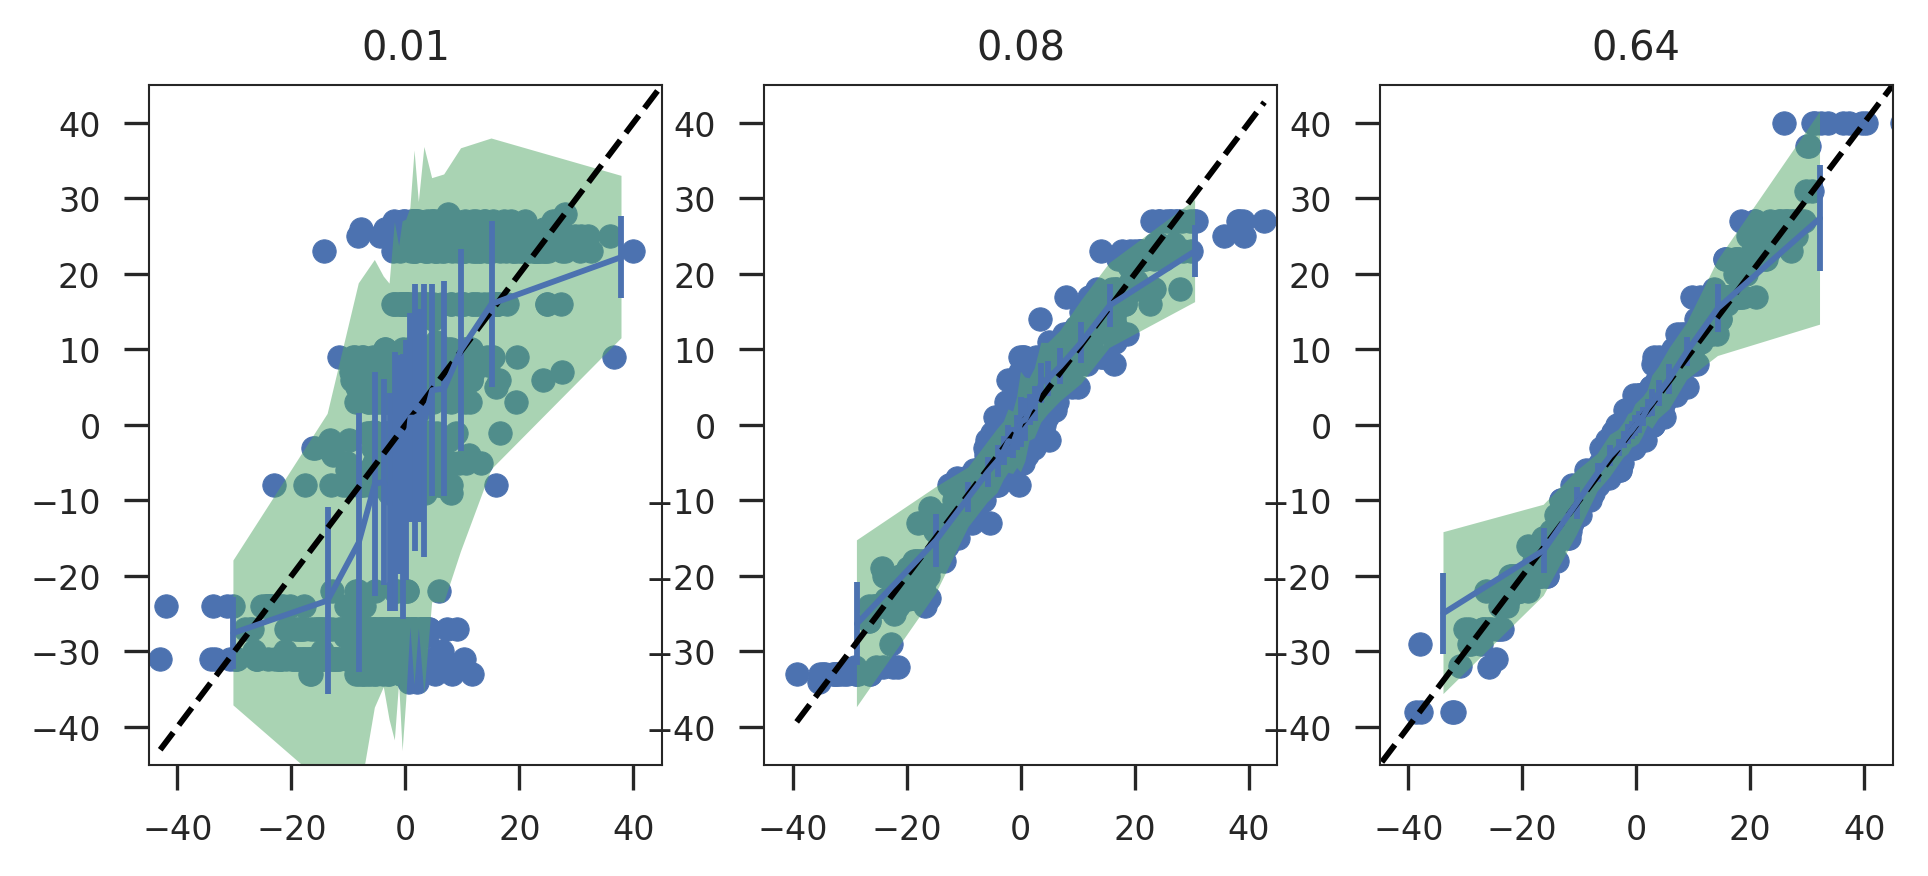

In [576]:
header = class_discrimination.CleanSpikeCountSet * class_discrimination.CSCLookup * cd_dataset.CleanContrastSessionDataSet.proj(dec_trainset_hash='dataset_hash')
restr = 'decoder_id = 4 and lc_shuffle_id = 0'
contrasts, max_ori, orientation = (LikelihoodStats * header & restr & session_key).fetch('contrasts', 'max_ori', 'orientation')

# we know that contrast is fixed for each of these contrast session
contrasts = np.array([c[0] for c in contrasts])
print(len(contrasts))
cpick = np.unique(contrasts)
fig, axs = plt.subplots(1, len(contrasts), figsize=(7.5, 3), dpi=300)
ori_edges = np.linspace(-40, 40, 12)
for c, ax in zip(cpick, axs.ravel()):
    assert len(np.where(contrasts==c)[0])==1, 'There should be only one entry!'
    #pos = np.random.choice(np.where(contrasts == c)[0])
    pos = np.where(contrasts == c)[0][0]
    ori = orientation[pos] - 270
    ori_hat = max_ori[pos] - 270
    selection = (ori > -30) & (ori < 30)
    #ori = ori[selection]
    #ori_hat = ori_hat[selection]
    ori_edges = np.percentile(ori, np.linspace(0, 100, 20))
    stats = binned_stats(ori, ori_hat, ori_edges)
    ax.scatter(ori, ori_hat)
    ax.errorbar(stats.binc, stats.mu, stats.sigma)
    ax.plot(ori_edges, ori_edges, 'k--')
    ax.fill_between(stats.binc, stats.mu-stats.sigma*2, stats.mu + stats.sigma*2, alpha=0.5)
    ax.set_xlim([-45, 45])
    ax.set_ylim([-45, 45])
    ax.set_title(c)